In [1]:
%load_ext autoreload
%autoreload 2

from collections import defaultdict
from itertools import chain, product
from pathlib import Path

import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from sklearn.metrics import precision_recall_curve, auc

In [2]:
fpath = Path('../data/prepared_data.csv')

In [3]:
data = pd.read_csv(fpath, index_col=0)

print(data.shape)

data.head(10)

(66370, 4)


,customer_id,mccs,mccs_count,transaction_month
0,0001f322716470bf9bfc1708f06f00fc,"6011,6011,6011,6011,6011,6011,6011",7,2
1,0001f322716470bf9bfc1708f06f00fc,"6011,6011,6011,6011,6011,6011,6011",7,3
2,0001f322716470bf9bfc1708f06f00fc,"5541,6011,6011,6011,6011,6011,6011,6011,6011",9,4
3,0001f322716470bf9bfc1708f06f00fc,"5411,5411,5541,5912,6011,6011,6011,6011,6011",9,5
4,0001f322716470bf9bfc1708f06f00fc,"5411,5411,5411,5411,5499,5541,5541,5999,5999,6...",18,6
5,0001f322716470bf9bfc1708f06f00fc,"5411,5411,5541,5999,6011,6011,6011",7,7
6,0001f322716470bf9bfc1708f06f00fc,"5411,5411,6011,6011,6011,6011,6011",7,8
7,0001f322716470bf9bfc1708f06f00fc,"5211,5411,5541,6011,6011,6011,6011,6011,6011,6...",11,9
8,0007297d86e14bd68bd87b1dbdefe302,"6011,6011,6011,6011,6011,6011",6,2
9,0007297d86e14bd68bd87b1dbdefe302,"6011,6011,6011,6011,6011,6011",6,3


In [4]:
months = sorted(data['transaction_month'].unique().tolist())
months

[1, 2, 3, 4, 5, 6, 7, 8, 9]

In [5]:
customers = data['customer_id'].unique().tolist()

len(customers)

9988

Распределение количества месяцев по пользователям.

In [6]:
data['customer_id'].value_counts().value_counts()

8    4362
6    1554
7    1309
5     846
4     616
9     478
3     452
2     264
1     107
Name: customer_id, dtype: int64

В столбце `mccs` в `data` записан список всех категорий товаров, приобретённых в данном месяце, разделённых запятой.

In [7]:
def deserialize_int_list(list_string: str) -> list:
    return [int(item) for item in list_string.split(',')]

In [8]:
data['mccs'] = data['mccs'].apply(deserialize_int_list)
data.head()

,customer_id,mccs,mccs_count,transaction_month
0,0001f322716470bf9bfc1708f06f00fc,"[6011, 6011, 6011, 6011, 6011, 6011, 6011]",7,2
1,0001f322716470bf9bfc1708f06f00fc,"[6011, 6011, 6011, 6011, 6011, 6011, 6011]",7,3
2,0001f322716470bf9bfc1708f06f00fc,"[5541, 6011, 6011, 6011, 6011, 6011, 6011, 601...",9,4
3,0001f322716470bf9bfc1708f06f00fc,"[5411, 5411, 5541, 5912, 6011, 6011, 6011, 601...",9,5
4,0001f322716470bf9bfc1708f06f00fc,"[5411, 5411, 5411, 5411, 5499, 5541, 5541, 599...",18,6


In [9]:
mccs = list(set(chain.from_iterable(data['mccs'])))
n_mccs = len(mccs)
mcc2id = dict(zip(mccs, range(n_mccs)))

n_mccs

243

Получаем векторы корзин с помощью Bag of words.

In [10]:
def get_bow_vector(mccs: list) -> np.ndarray:
    vector = np.zeros(n_mccs)
    
    for mcc in mccs:
        mid = mcc2id[mcc]
        vector[mid] += 1
        
    return vector

In [11]:
data['vector'] = data['mccs'].apply(get_bow_vector)
data.head()

,customer_id,mccs,mccs_count,transaction_month,vector
0,0001f322716470bf9bfc1708f06f00fc,"[6011, 6011, 6011, 6011, 6011, 6011, 6011]",7,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,0001f322716470bf9bfc1708f06f00fc,"[6011, 6011, 6011, 6011, 6011, 6011, 6011]",7,3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,0001f322716470bf9bfc1708f06f00fc,"[5541, 6011, 6011, 6011, 6011, 6011, 6011, 601...",9,4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,0001f322716470bf9bfc1708f06f00fc,"[5411, 5411, 5541, 5912, 6011, 6011, 6011, 601...",9,5,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,0001f322716470bf9bfc1708f06f00fc,"[5411, 5411, 5411, 5411, 5499, 5541, 5541, 599...",18,6,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [47]:
def get_data(months: list):
    x = []
    y = []
    
    for cid in tqdm(customers):
        cdata = data[data['customer_id'] == cid]
        cmonths = set(cdata['transaction_month'].tolist())
        
        if all(month in cmonths for month in months):
            vectors = cdata.loc[cdata['transaction_month'].isin(months), 'vector'].values.tolist()
            x_ = np.array(vectors[:-1])
            y_ = vectors[-1]
                    
            x.append(x_)
            y.append(y_)
        
    return x, y

In [49]:
n_months = 4

x_train = []
y_train = []
x_test = []
y_test = []

for i in range(len(months) - n_months + 1):
    months_ = months[i:i + n_months]
    
    print(f'months: {months_}')
    
    x, y = get_data(months=months_)
    
    if months_[-1] == 9:
        x_test.extend(x)
        y_test.extend(y)
    
    else:
        x_train.extend(x)
        y_train.extend(y)
        
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

months: [1, 2, 3, 4]



months: [2, 3, 4, 5]



months: [3, 4, 5, 6]



months: [4, 5, 6, 7]



months: [5, 6, 7, 8]



months: [6, 7, 8, 9]


In [50]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(27018, 3, 243) (27018, 243)
(7304, 3, 243) (7304, 243)


In [51]:
model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=x_train[0].shape),
    tf.keras.layers.LSTM(256),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(n_mccs, activation='sigmoid'),
])

In [53]:
model.compile(
    optimizer='adam',
    loss='mse',
)

In [54]:
model.fit(
    x_train, y_train,
    epochs=10,
    validation_data=(x_test, y_test),
)

Train on 27018 samples, validate on 7304 samples
Epoch 1/10
27018/27018 [==============================] - 9s 320us/sample - loss: 14.6528 - val_loss: 13.3525
Epoch 2/10
27018/27018 [==============================] - 8s 281us/sample - loss: 13.7155 - val_loss: 13.1895
Epoch 3/10
27018/27018 [==============================] - 8s 290us/sample - loss: 13.5348 - val_loss: 13.0788
Epoch 4/10
27018/27018 [==============================] - 8s 291us/sample - loss: 13.4100 - val_loss: 13.0554
Epoch 5/10
27018/27018 [==============================] - 8s 290us/sample - loss: 13.3032 - val_loss: 13.0667
Epoch 6/10
27018/27018 [==============================] - 8s 287us/sample - loss: 13.2029 - val_loss: 13.0913
Epoch 7/10
27018/27018 [==============================] - 8s 281us/sample - loss: 13.0955 - val_loss: 13.1169
Epoch 8/10
27018/27018 [==============================] - 8s 290us/sample - loss: 12.9831 - val_loss: 13.1542
Epoch 9/10
27018/27018 [==============================] - 8s 286us/samp

In [55]:
y_pred = model.predict(x_test)
y_pred.shape

(7304, 243)

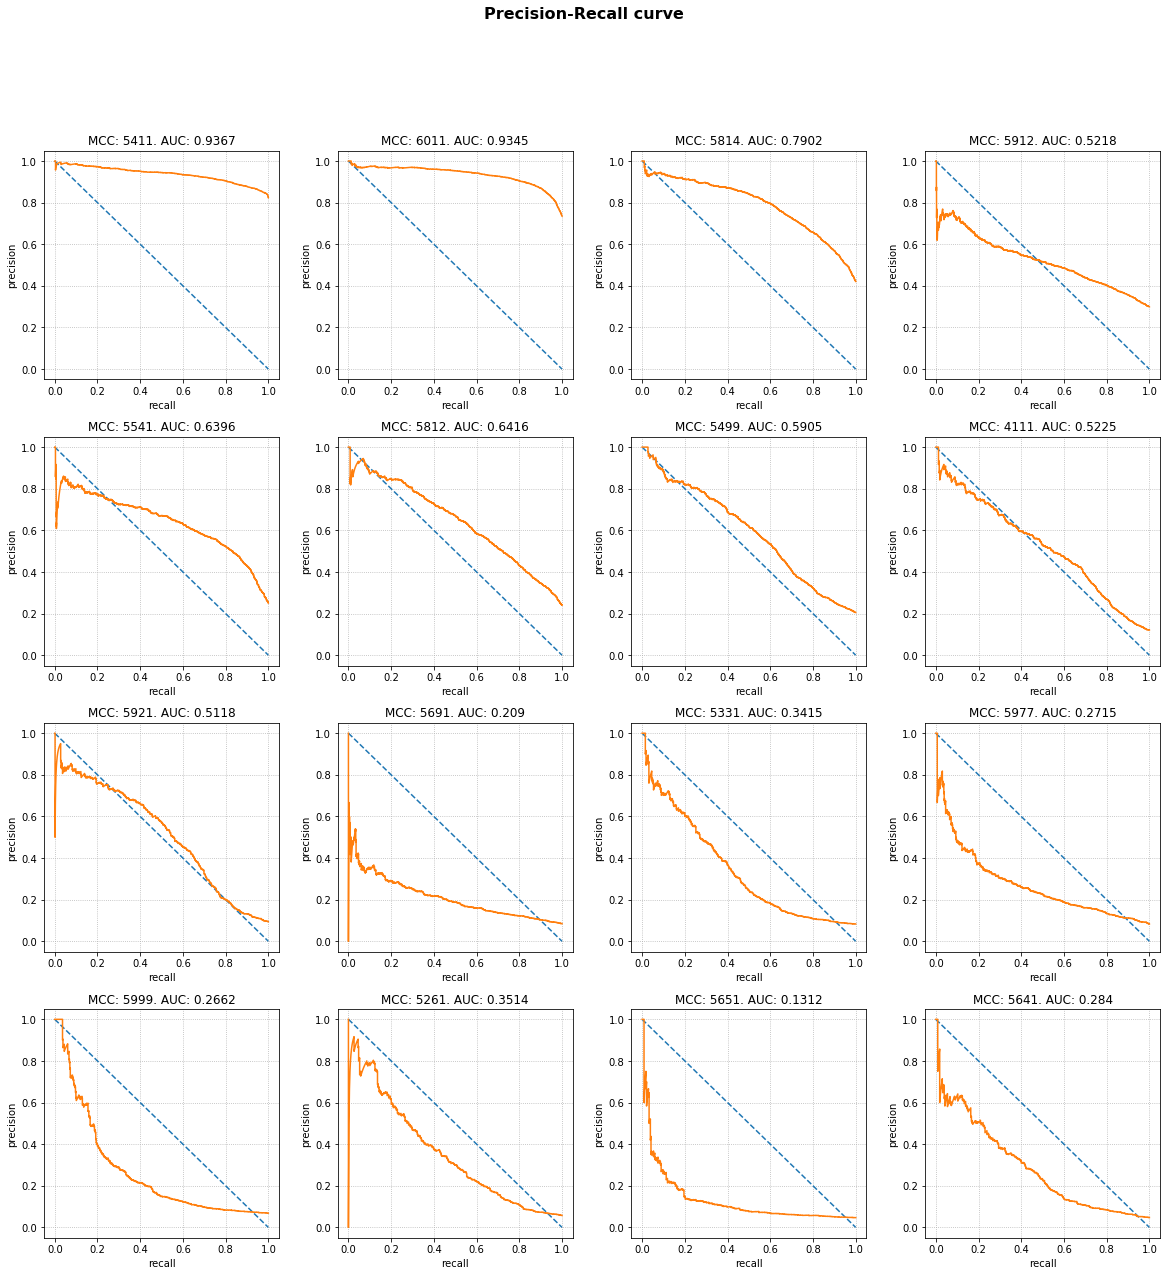

In [56]:
fig, axes = plt.subplots(nrows=4, ncols=4)
plt.subplots_adjust(wspace=0.25, hspace=0.25)
fig.set_size_inches(20, 20)
axes = axes.flatten()

fig.suptitle('Precision-Recall curve', fontsize=16, fontweight='bold')

for mid, ax in zip(y_test.sum(axis=0).argsort()[::-1], axes):
    mcc = mccs[mid]

    x, y, _ = precision_recall_curve(y_test[:, mid] > 0, y_pred[:, mid])
    score = auc(y, x)

    ax.plot([0, 1], [1, 0], ls='dashed')
    ax.plot(y, x)

    ax.set_title(f'MCC: {mcc}. AUC: {round(score, 4)}')
    ax.set_xlabel('recall')
    ax.set_ylabel('precision')
    ax.grid(linestyle='dotted')